Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Statistical summary:
        SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%   

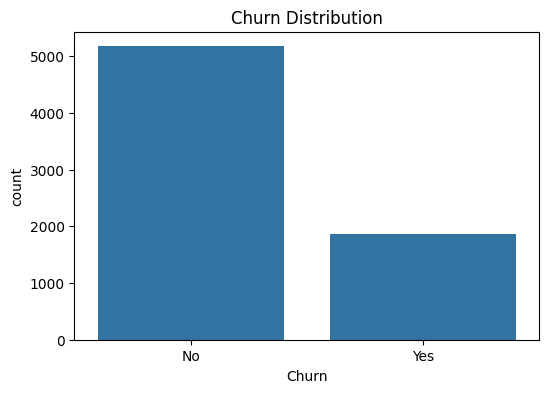

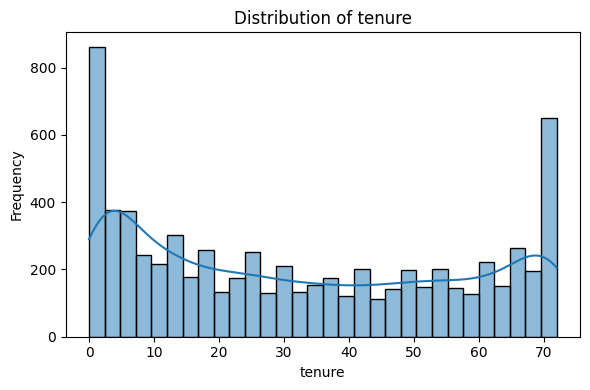

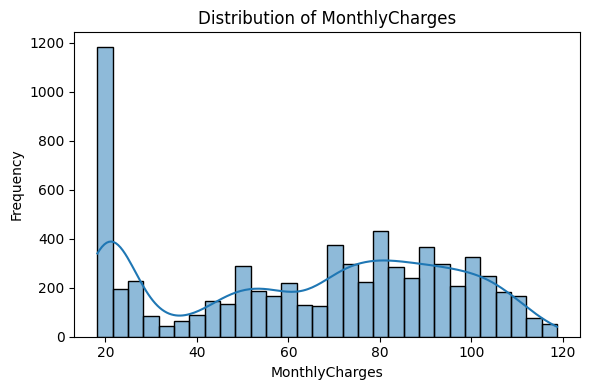

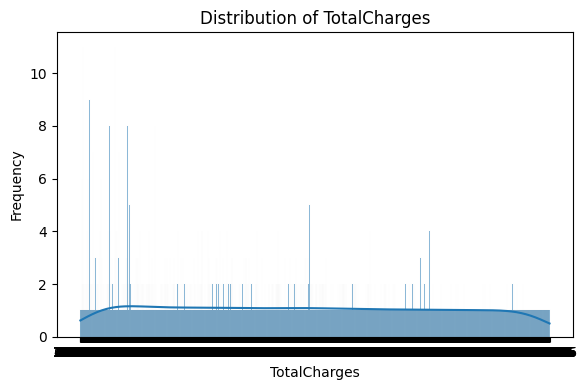

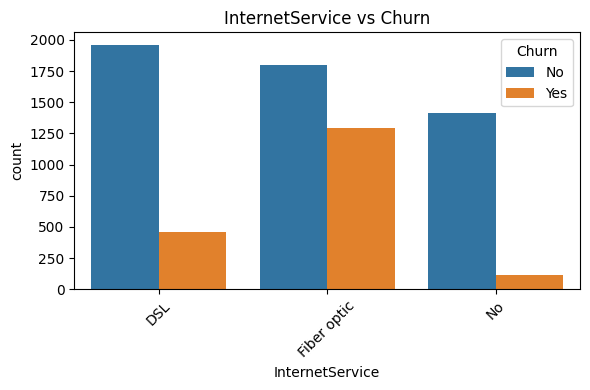

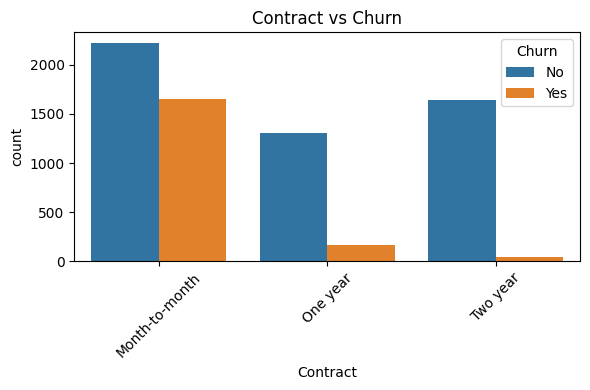

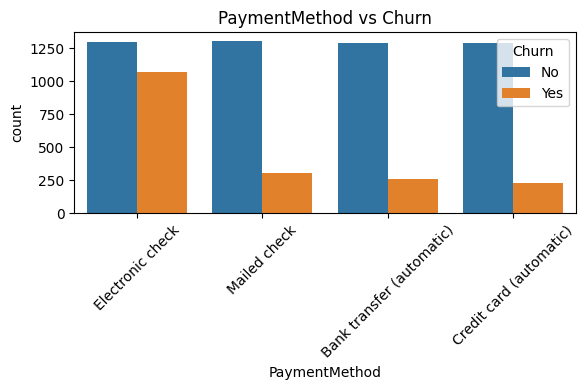

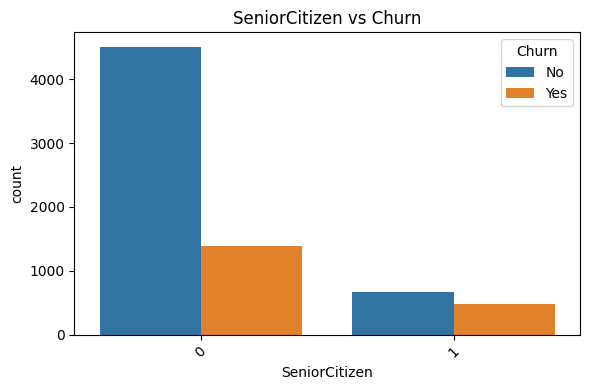

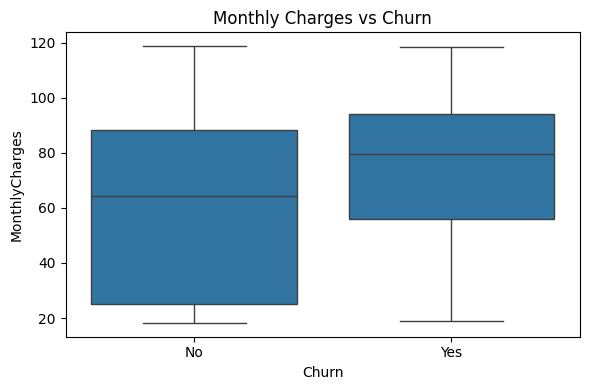

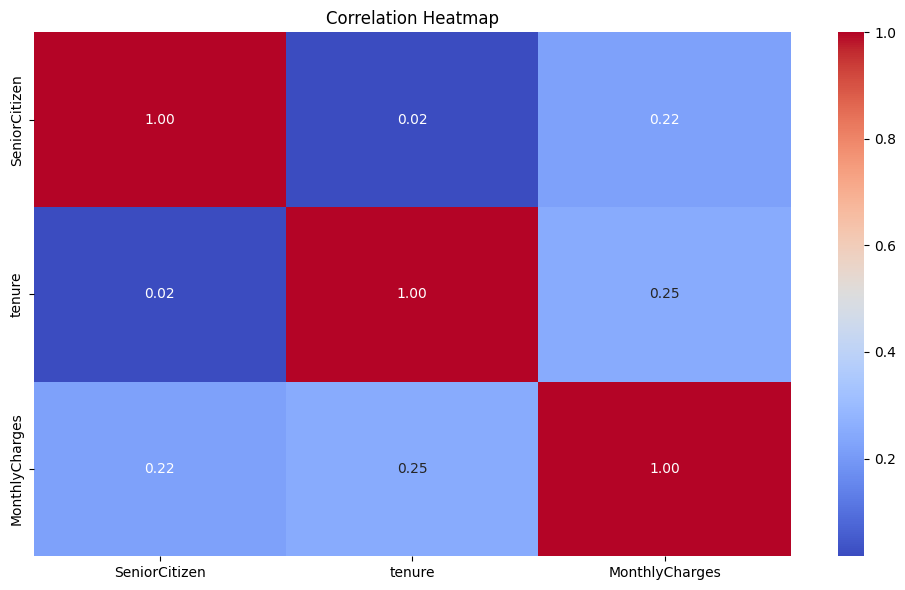

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
{'R2 Score': 0.7964980795201181, 'MSE Loss': 182.7871745168615}


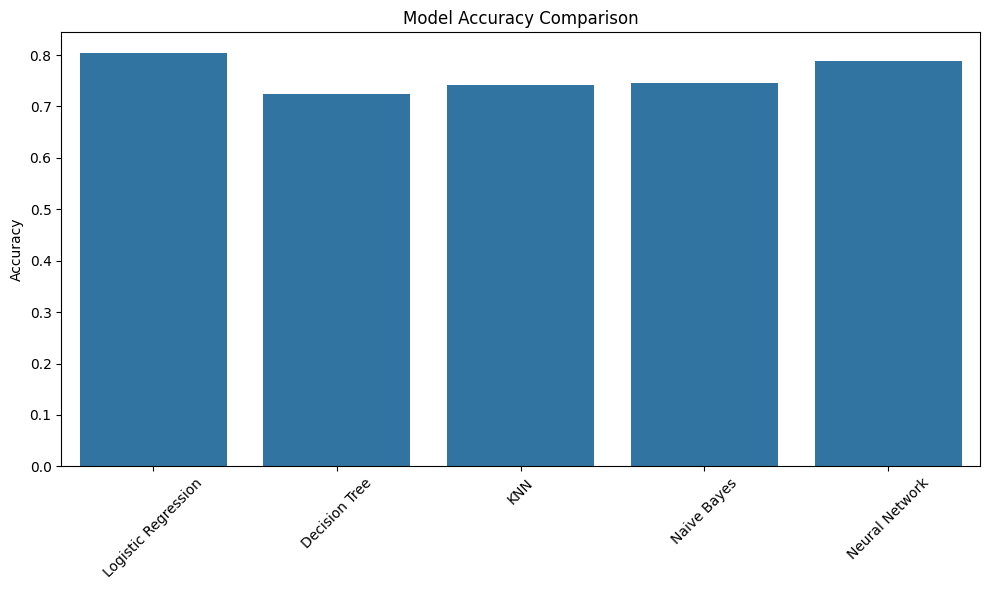

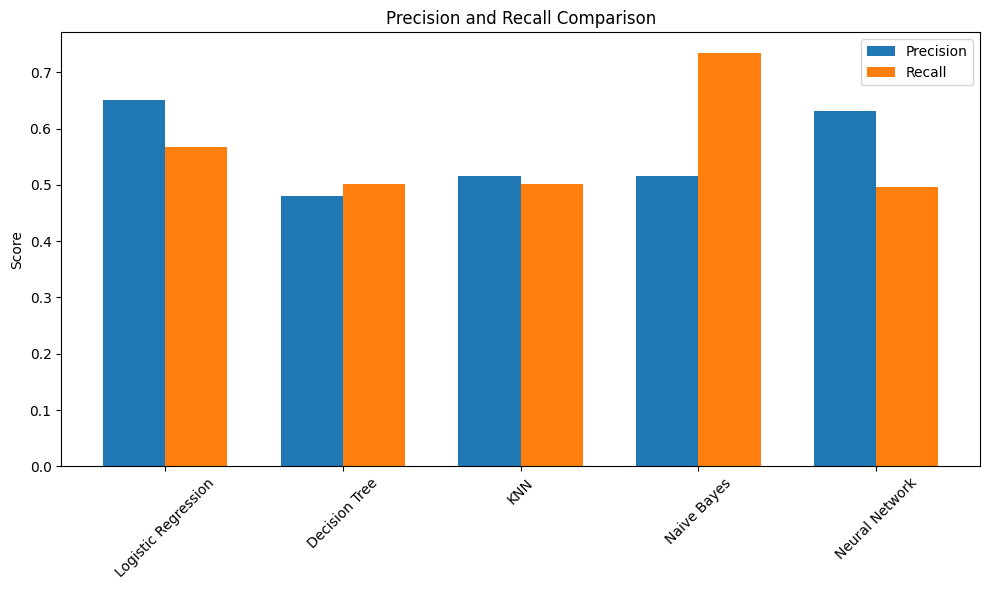

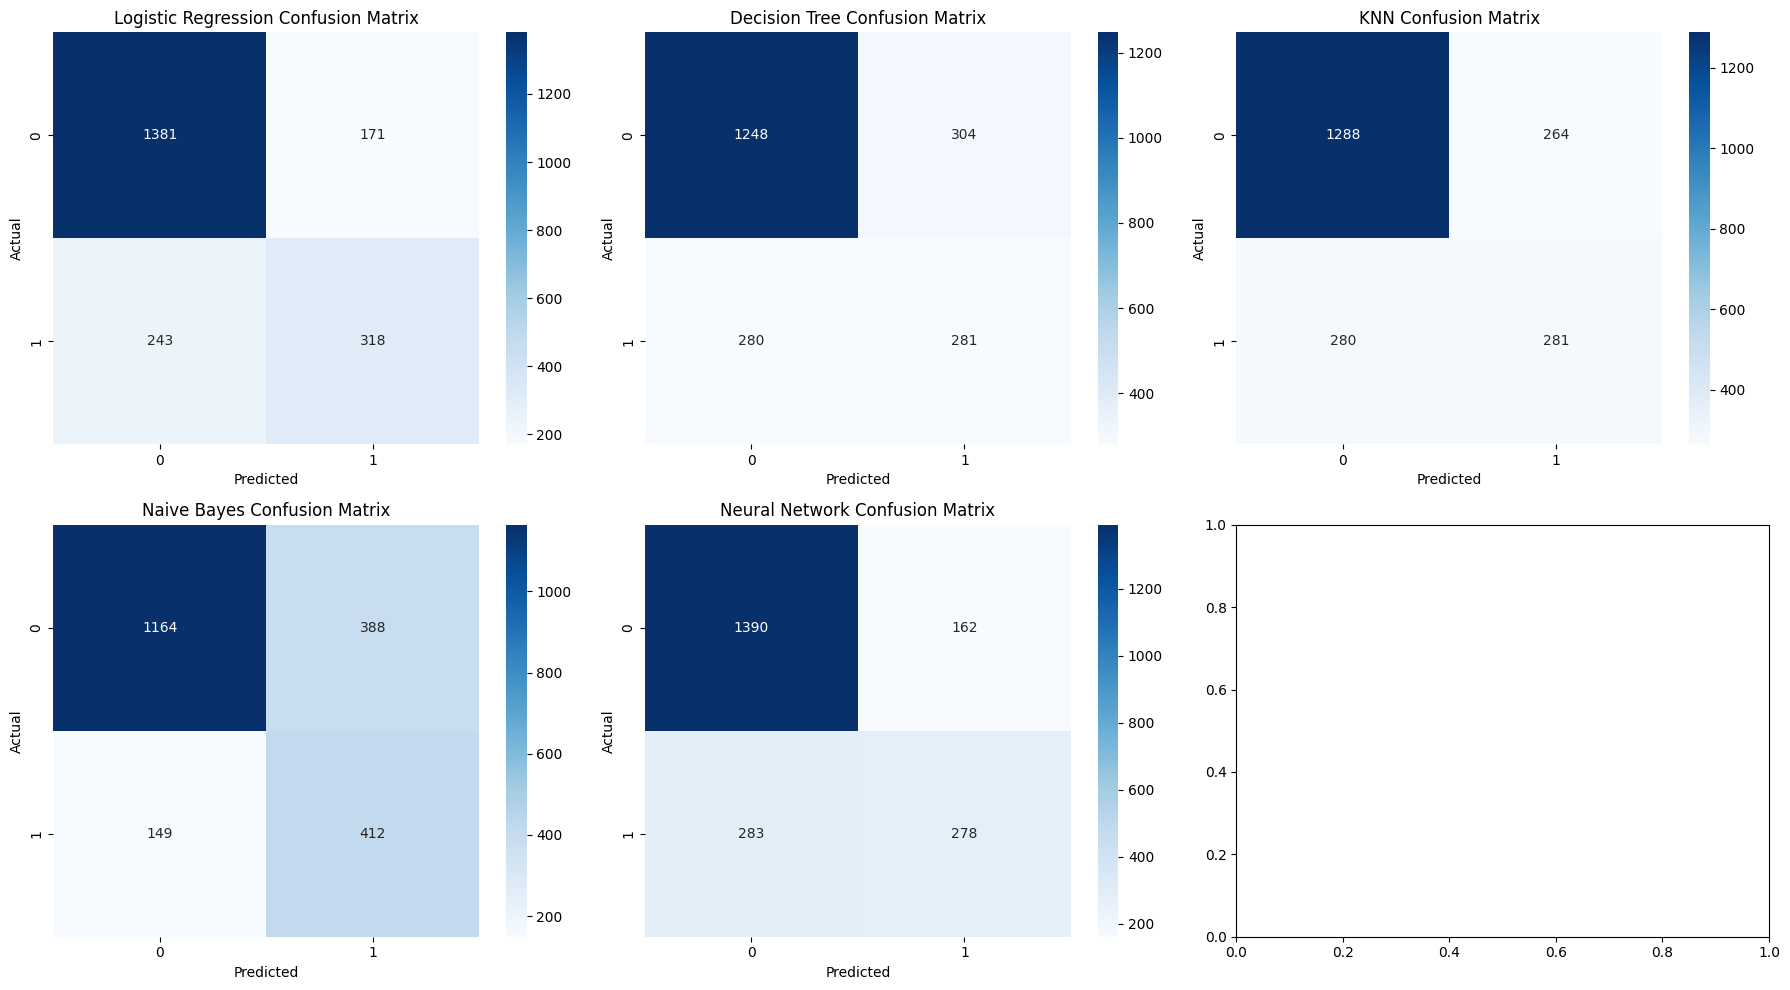

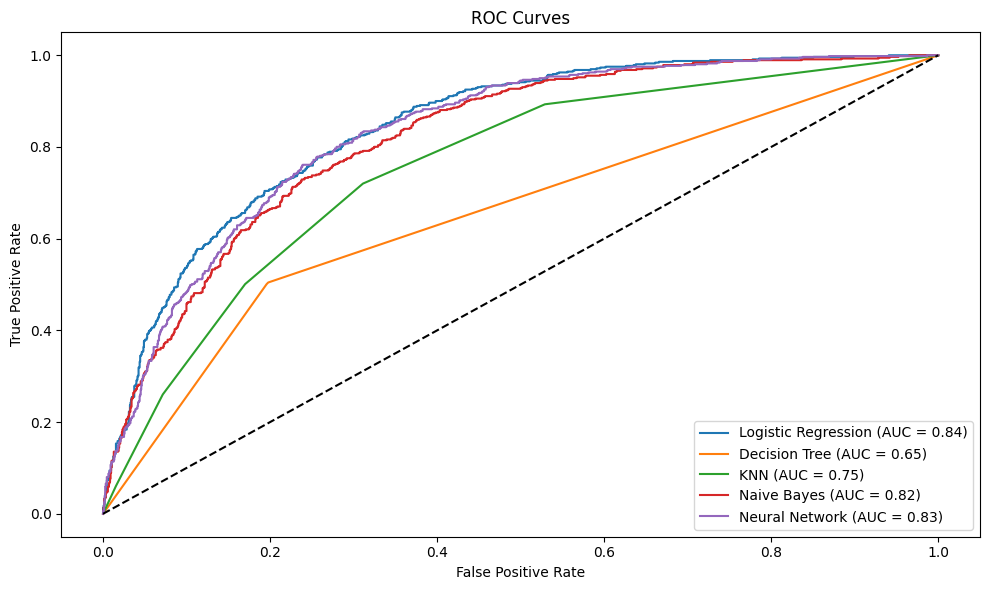

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.804070   0.650307  0.566845  0.605714  0.842819
1        Decision Tree  0.723616   0.480342  0.500891  0.490401  0.653458
2                  KNN  0.742546   0.515596  0.500891  0.508137  0.754609
3          Naive Bayes  0.745859   0.515000  0.734403  0.605437  0.819925
4       Neural Network  0.789399   0.631818  0.495544  0.555445  0.832189


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# !pip install tensorflow

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, confusion_matrix,
    roc_auc_score, roc_curve, classification_report, r2_score, mean_squared_error
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

df = pd.read_csv('/content/drive/MyDrive/telco_customer_churn.csv')
df.head()

#EDA

print("Missing values:\n", df.isnull().sum())

print("\nStatistical summary:\n", df.describe())

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

cat_cols = ['InternetService', 'Contract', 'PaymentMethod', 'SeniorCitizen']
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.title('Monthly Charges vs Churn')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

imputer = SimpleImputer(strategy='median')
df['TotalCharges'] = imputer.fit_transform(df[['TotalCharges']])

for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop('Churn', axis=1)
y = df['Churn']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else None,
        'ROC Curve': roc_curve(y_test, y_prob) if y_prob is not None else None
    }

nn = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.3)

nn_pred = (nn.predict(X_test) > 0.5).astype(int).flatten()
nn_prob = nn.predict(X_test).flatten()

results['Neural Network'] = {
    'Accuracy': accuracy_score(y_test, nn_pred),
    'Precision': precision_score(y_test, nn_pred),
    'Recall': recall_score(y_test, nn_pred),
    'Confusion Matrix': confusion_matrix(y_test, nn_pred),
    'ROC AUC': roc_auc_score(y_test, nn_prob),
    'ROC Curve': roc_curve(y_test, nn_prob)
}

reg_y = df['MonthlyCharges']
reg_X = df.drop(columns=['MonthlyCharges', 'Churn'])
reg_X_scaled = scaler.fit_transform(reg_X)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    reg_X_scaled, reg_y, test_size=0.3, random_state=42
)

reg_model = LinearRegression()
reg_model.fit(X_train_r, y_train_r)
reg_pred = reg_model.predict(X_test_r)

reg_results = {
    'R2 Score': r2_score(y_test_r, reg_pred),
    'MSE Loss': mean_squared_error(y_test_r, reg_pred)
}

print(reg_results)

plt.figure(figsize=(10, 6))
model_names = list(results.keys())
accuracies = [results[m]['Accuracy'] for m in model_names]
sns.barplot(x=model_names, y=accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

precisions = [results[m]['Precision'] for m in model_names]
recalls = [results[m]['Recall'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, precisions, width, label='Precision')
plt.bar(x + width/2, recalls, width, label='Recall')
plt.xticks(x, model_names, rotation=45)
plt.ylabel('Score')
plt.title('Precision and Recall Comparison')
plt.legend()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, model_name in enumerate(model_names):
    sns.heatmap(results[model_name]['Confusion Matrix'], annot=True, fmt='d', ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f'{model_name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for name in model_names:
    fpr, tpr, _ = results[name]['ROC Curve']
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['ROC AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()


from sklearn.metrics import f1_score
import pandas as pd

comparison_data = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": [],
    "ROC AUC": []
}

for model_name, metrics in results.items():
    # Get predictions again (some models may not store them)
    if model_name == 'Neural Network':
        preds = (nn_prob > 0.5).astype(int)
    else:
        preds = models[model_name].predict(X_test)

    f1 = f1_score(y_test, preds)

    comparison_data["Model"].append(model_name)
    comparison_data["Accuracy"].append(metrics["Accuracy"])
    comparison_data["Precision"].append(metrics["Precision"])
    comparison_data["Recall"].append(metrics["Recall"])
    comparison_data["F1 Score"].append(f1)
    comparison_data["ROC AUC"].append(metrics["ROC AUC"])

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)
